In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import matplotlib.image as pltimg
import graphviz 

############################
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor,VotingClassifier,RandomForestClassifier
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, KFold, train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error,r2_score
from sklearn.tree._export import plot_tree



C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Windows-10-10.0.18362-SP0
Python 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
NumPy 1.18.1
SciPy 1.4.1
Scikit-Learn 0.22.1


In [6]:
#from google.colab import drive

#drive.mount('/content/gdrive')
#root_path = 'gdrive/My Drive/your_project_folder/'  #change dir to your project folder

In [4]:
df_Alagoas = pd.read_csv('../microdadosEnemAlagoas.csv', sep = ';', encoding='ISO 8859-1')
df_Alagoas

Unnamed: 0  NU_INSCRICAO SG_UF_RESIDENCIA  NU_IDADE  TP_SEXO  \
0             193  180008411121               AL      19.0      1.0   
1             283  180008788016               AL      40.0      0.0   
2             305  180008411503               AL      24.0      1.0   
3             336  180008257102               AL      28.0      0.0   
4             372  180008309661               AL      17.0      1.0   
...           ...           ...              ...       ...      ...   
64600     5513028  180013469026               AL      34.0      1.0   
64601     5513039  180013985741               AL      20.0      0.0   
64602     5513342  180013955750               AL      18.0      1.0   
64603     5513369  180013983882               AL      18.0      1.0   
64604     5513524  180012390551               AL      18.0      1.0   

       TP_ESTADO_CIVIL  TP_COR_RACA  TP_ANO_CONCLUIU  TP_ESCOLA  IN_TREINEIRO  \
0                  0.0          3.0              1.0        1.0           0.0   
1                  2.0          3.0              6.0        1.0           0.0   
2                  0.0          3.0              7.0        1.0           0.0   
3                  0.0          3.0              8.0        1.0           0.0   
4                  0.0          3.0              0.0        1.0           0.0   
...                ...          ...              ...        ...           ...   
64600              0.0          3.0              0.0        1.0           0.0   
64601              0.0          3.0              2.0        1.0           0.0   
64602              0.0          3.0              0.0        2.0           0.0   
64603              0.0          2.0              0.0        1.0           0.0   
64604              0.0          1.0              1.0        1.0           0.0   

       ...  Q018  Q019  Q020  Q021  Q022 Q023 Q024 Q025 Q026  Q027  
0      ...     A     B     B     A     B    A    B    B    A     A  
1      ...     A     B     B     A     B    A    A    B    A     A  
2      ...     B     B     B     A     B    A    A    B    A     C  
3      ...     A     B     A     A     D    A    A    B    A     A  
4      ...     A     C     B     A     C    A    A    A    B     A  
...    ...   ...   ...   ...   ...   ...  ...  ...  ...  ...   ...  
64600  ...     A     B     A     B     B    B    B    A    A     A  
64601  ...     A     B     A     A     B    A    A    B    A     A  
64602  ...     A     A     A     A     B    A    A    A    B     A  
64603  ...     A     B     B     A     C    A    B    B    B     B  
64604  ...     A     B     A     A     B    A    A    B    A     E  

[64605 rows x 42 columns]

In [5]:
df_Alagoas = df_Alagoas.loc[:, ~df_Alagoas.columns.str.contains('^Unnamed')]
#df_Alagoas = df_Alagoas[0:10000]

feature_cols = [x for x in df_Alagoas.columns if x != 'NU_NOTA_MT']
X = df_Alagoas[feature_cols]
Y = df_Alagoas['NU_NOTA_MT']



In [6]:
df_Alagoas.shape

(64605, 41)

# Variável alvo é a nota de matematica dos participantes

In [7]:
# Leitura dos datasets de treino e teste e criação do df de resposta
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=0)
#df_resposta = pd.DataFrame()
print(X.shape, Y.shape, X_train.shape, y_train.shape ,X_test.shape, y_test.shape)

(64605, 40) (64605,) (45223, 40) (45223,) (19382, 40) (19382,)


# Pré-processamento

In [8]:
#dataframe que irá receber a resposta dada pelo sistema
df_resposta = pd.DataFrame()

#dataframe que guarda a nota orginal obtida pelo participante
df_resposta['NU_INSCRICAO'] = X_test['NU_INSCRICAO']
df_resposta['NU_NOTA_MT'] = y_test

In [9]:
numeric_features = ['NU_IDADE', 'TP_SEXO','TP_ESTADO_CIVIL', 'TP_COR_RACA','TP_ANO_CONCLUIU', 'TP_ESCOLA',
                    'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO',  'Q005']

numeric_transformer = Pipeline(   steps=[ ('scaler', StandardScaler())])

categorical_features = ['Q001', 'Q002', 'Q003', 'Q004','Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011','Q012', 'Q013', 'Q014',
                        'Q015','Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

X_train = X_train[numeric_features + categorical_features]
X_test = X_test[numeric_features + categorical_features]

preprocessing = ColumnTransformer(transformers=[
                                        ('num', numeric_transformer, numeric_features),                                       
                                        ('cat', categorical_transformer, categorical_features),  
])

In [10]:
feature_names= numeric_features + categorical_features
len(feature_names)
print(feature_names)

['NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'Q005', 'Q001', 'Q002', 'Q003', 'Q004', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']


# Aplicando o regressor

## Random Forest

In [11]:
#rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42 )
rf = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42 ))
])
rf.fit(X_train, y_train)
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))
#y_pred = rf.predict(X_test)



#print(y_pred)

RF train accuracy: 0.893
RF test accuracy: 0.402


## Regressão Linear

In [12]:
lr =  Pipeline([
    ('preprocess', preprocessing),
    ('regressor', LinearRegression())
])
lr.fit(X_train, y_train)

# score = Return the coefficient of determination R^2 of the prediction
print("RN train R²: %0.3f" % lr.score(X_train, y_train))
print("RN test R²: %0.3f" % lr.score(X_test, y_test))

RN train R²: 0.438
RN test R²: 0.438


## Rede neural

In [18]:
rn = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', MLPRegressor(hidden_layer_sizes=(50, 50),tol=1e-2,max_iter=500, random_state=0))
])
rn.fit(X_train, y_train)

# score = Return the coefficient of determination R^2 of the prediction
print("RN train R²: %0.3f" % rn.score(X_train, y_train))
print("RN test R²: %0.3f" % rn.score(X_test, y_test))

RN train R²: 0.485
RN test R²: 0.461


# Árvore de decisão

In [14]:
dtree = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', DecisionTreeRegressor(random_state=0))
])
dtree.fit(X_train, y_train)

# # score = Return the coefficient of determination R^2 of the prediction
print("Coefficient of determination R² of the prediction train.: %0.3f" % dtree.score(X_train, y_train))
print("Coefficient of determination R² of the prediction test: %0.3f" % dtree.score(X_test, y_test))
#x = dtree.named_steps['regressor'].feature_importances_


Coefficient of determination R² of the prediction train.: 1.000
Coefficient of determination R² of the prediction test: -0.112


In [15]:
#df_resposta['NU_NOTA_MT_predRF'] = y_pred
df_metricas = pd.DataFrame()
df_resposta.shape

df_features_importance =  pd.DataFrame()


In [16]:
def GuardaFeatures(clf, label):
    
    df_features_importance[label] = clf.named_steps['regressor'].feature_importances_
            
    ohe                           = (clf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'])
            
    feature_names                 = ohe.get_feature_names(input_features=categorical_features)
            
    df_features_importance['feature_names' + label] =  np.r_[feature_names, numeric_features] 
    

# Aplicando os regressores

In [17]:
import time
scorings=['r2']

clfs = [rf, lr, rn, dtree]
start_time = time.time()
valores=[]
i=0
for clf, label in zip(clfs, ['Random Forest', 'Regressão Linear', 'Rede Neural', 'Árvore de decisão']):
    
        tempro_processamento = time.time()
        
        print( "Processando o modelo: [%s]" % label)
        
       # cv = cross_validate(clf, X_train, y_train, cv=5,  n_jobs=-1, verbose=0, return_train_score=True)        
        cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
        
        y_pred = cross_val_predict(clf, X_test, y_test, n_jobs=-1, verbose=0)     
        
        df_resposta['NU_NOTA_MT_'+ label] = y_pred
        
        df_metricas['Modelo']                    = ['Random Forest', 'Regressão Linear', 'Rede Neural', 'Árvore de decisão']
        
        df_metricas.loc[i,'Max_Error']           = round(max_error(y_test, y_pred), 2)
        df_metricas.loc[i,'MAE']                 = round(mean_absolute_error(y_test, y_pred), 2)         
        df_metricas.loc[i,'R²']                  = round(r2_score(y_test, y_pred), 2)
        df_metricas.loc[i,'MSE']                 = round(mean_squared_error(y_test, y_pred), 2)
        df_metricas.loc[i,'CV scores mean']      = round(cv_scores.mean(), 2)
        df_metricas.loc[i,'CV scores std']       = round(cv_scores.std(), 2)
          
        
      
        if(label == "Random Forest"):
           
            GuardaFeatures(clf, label)
           
        elif(label == "Árvore de decisão"):
            
            GuardaFeatures(clf, label)
            
            
        tempo = (time.time() - tempro_processamento)
        tempoMinutos =  tempo/60  
        df_metricas.loc[i, 'Tempo de processamento min'] = round( tempoMinutos, 2)
        
        print("Tempo de processamento [%s] em minutos: %f  " %( label, round( tempoMinutos, 2) ) )
        print('\n')
        i+=1
       
        #print("Accuracy: %0.2f (+/- %0.2f) [%s]" % ( cv_scores.mean(),  cv_scores.std(), label))
        
       
    
    
elapsed_time = time.time() - start_time

print("tempo de processamento total em minutos:" , (round(elapsed_time/60, 2)))
print('Processamento finalizado')
#print(elapsed_time)

Processando o modelo: [Random Forest]
Tempo de processamento [Random Forest] em minutos: 9.010000  


Processando o modelo: [Regressão Linear]
Tempo de processamento [Regressão Linear] em minutos: 0.290000  


Processando o modelo: [Rede Neural]


C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Tempo de processamento [Rede Neural] em minutos: 20.200000  


Processando o modelo: [Árvore de decisão]
Tempo de processamento [Árvore de decisão] em minutos: 2.190000  


tempo de processamento total em minutos: 31.69
Processamento finalizado


# Transformando para float 64 e com uma casa decimal

In [19]:

df_resposta[['NU_NOTA_MT_Random Forest','NU_NOTA_MT_Regressão Linear','NU_NOTA_MT_Rede Neural']]= df_resposta[['NU_NOTA_MT_Random Forest','NU_NOTA_MT_Regressão Linear','NU_NOTA_MT_Rede Neural' ]].applymap("{0:.1f}".format).astype('float64')



In [20]:
df_metricas


Modelo  Max_Error    MAE    R²       MSE  CV scores mean  \
0      Random Forest     485.11  58.77  0.40   5428.39            0.40   
1   Regressão Linear     513.67  57.01  0.44   5072.02            0.43   
2        Rede Neural     499.38  55.96  0.45   4965.24            0.45   
3  Árvore de decisão     647.80  78.71 -0.12  10057.61           -0.11   

   CV scores std  Tempo de processamento min  
0           0.01                        9.01  
1           0.01                        0.29  
2           0.02                       20.20  
3           0.01                        2.19

# Salvando os dataframes com os resultados

In [21]:
#Salvar num arquivo csv o dataframe com os dados de Alagoas

df_resposta.to_csv('microdadosRespostaAlagoas.csv', sep = ';', encoding='ISO 8859-1')
df_features_importance.to_csv('microdadosFeaturesImportancesAL.csv', sep = ';', encoding='ISO 8859-1')
df_metricas.to_csv('microdadosMetricasAL.csv', sep = ';', encoding='ISO 8859-1')

# Features Importances - Ramdom Forest - Alagoas

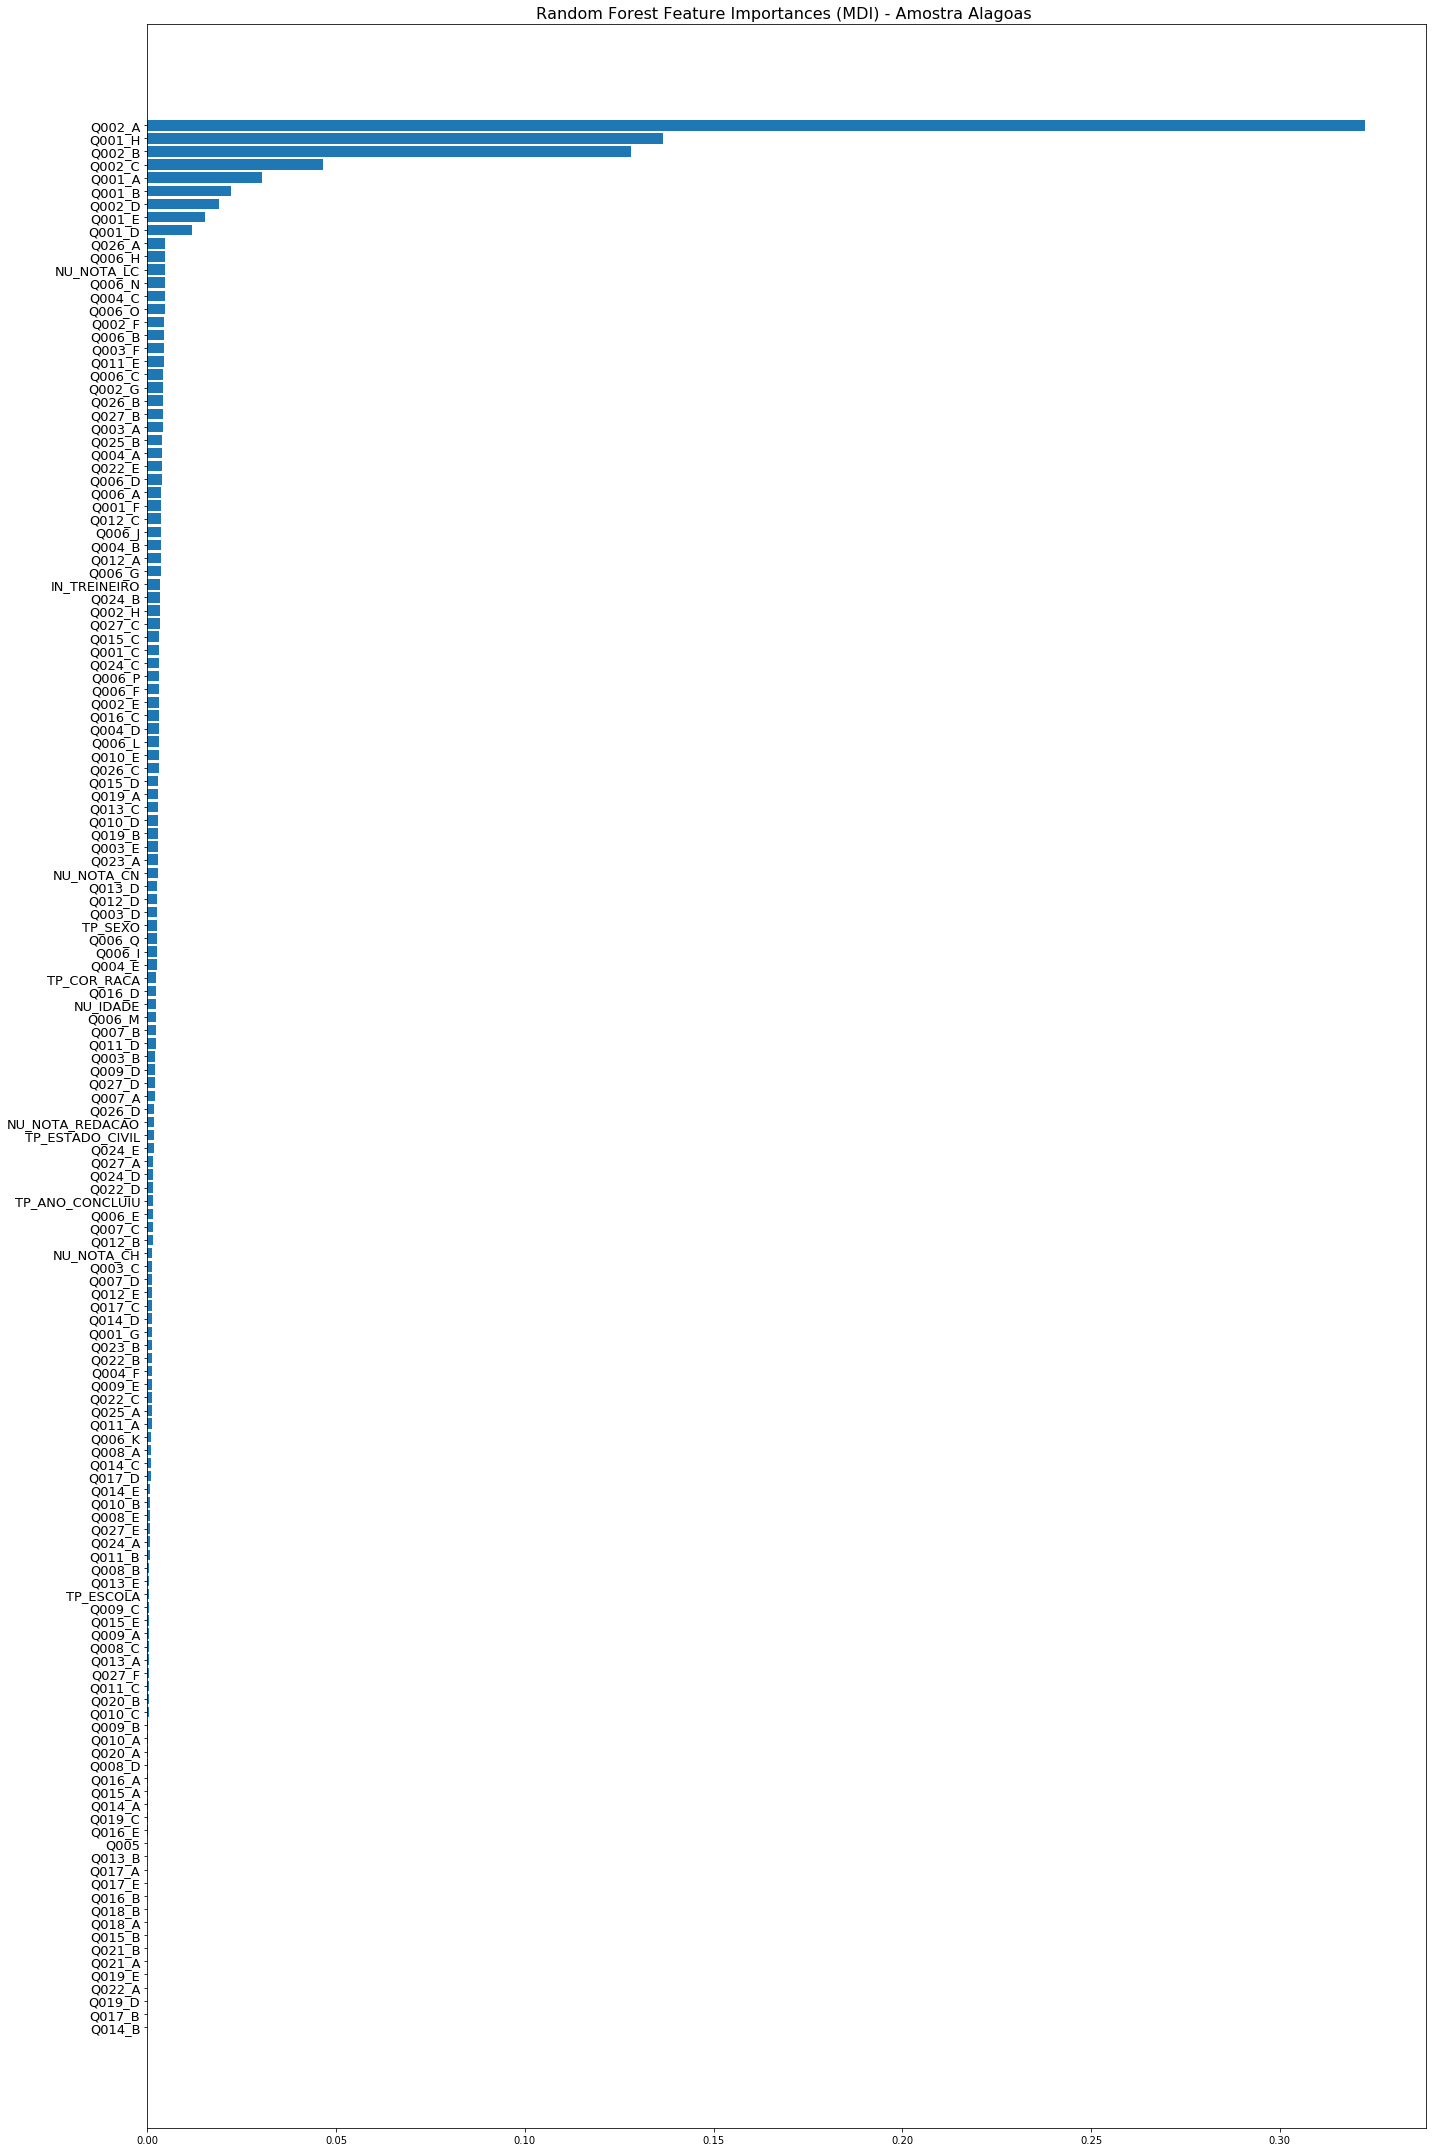

In [23]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (rf.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 30))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) - Amostra Alagoas ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesRF_AL_MT.png', format='png')
plt.show()

# Features Importances - Árvore de Decisão - Alagoas

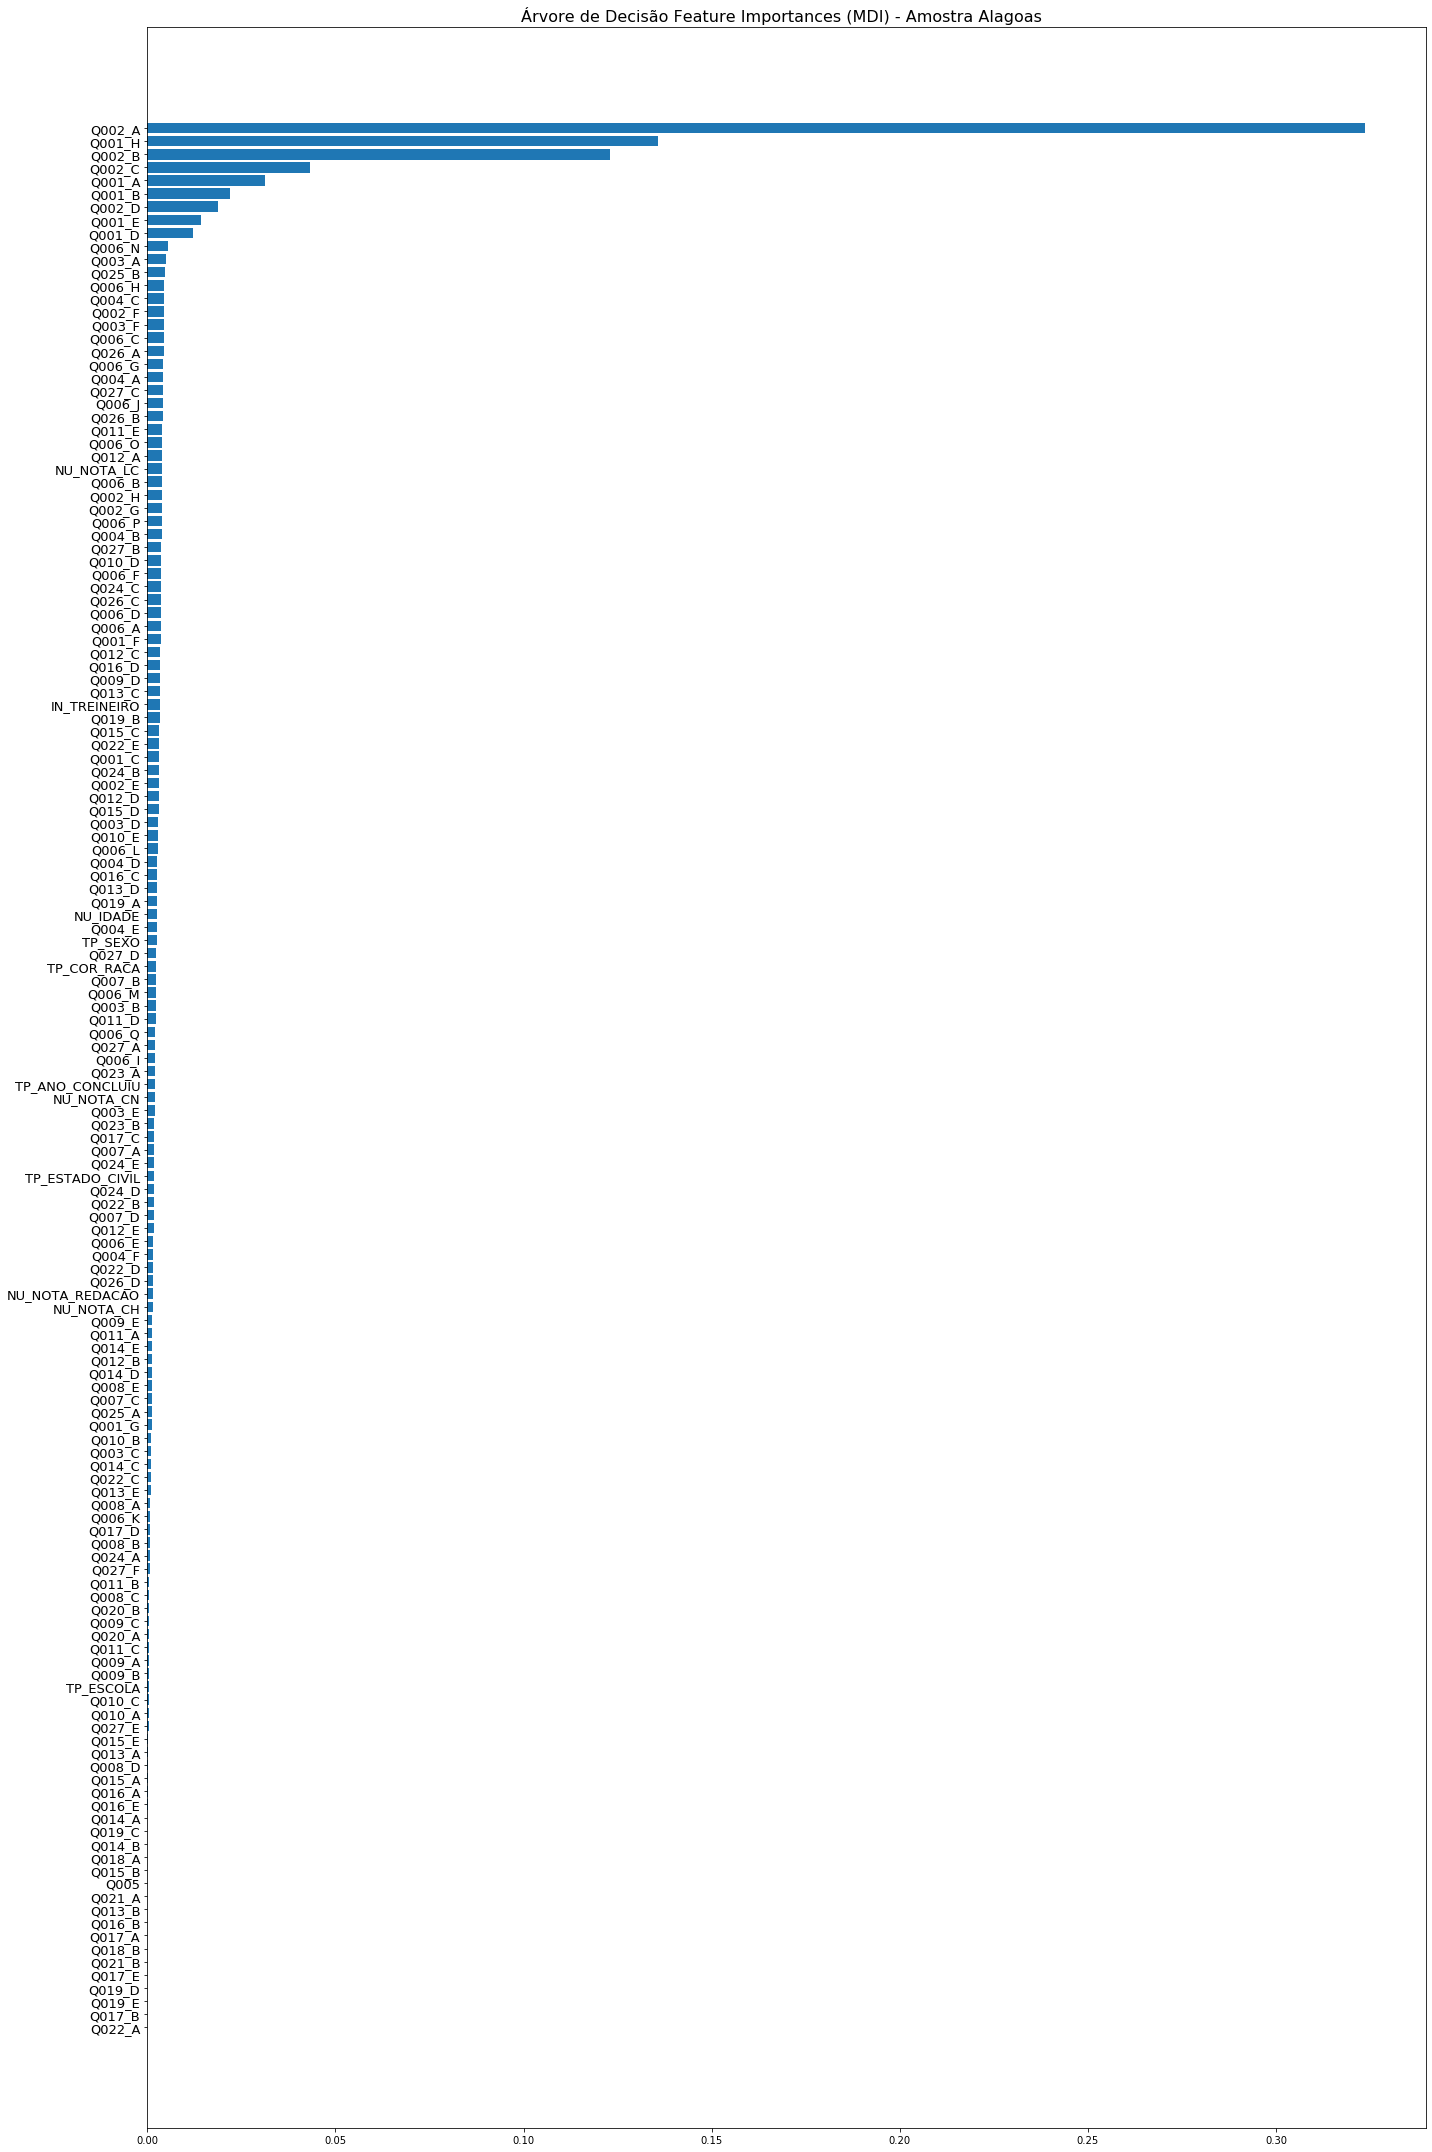

In [25]:
ohe = (dtree.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (dtree.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 30))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Árvore de Decisão Feature Importances (MDI) - Amostra Alagoas  ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesDT_AL_MT.png', format='png')
plt.show()

# Permutation Importances - Random Forest - Alagoas

TypeError: set_ylabel() missing 1 required positional argument: 'ylabel'

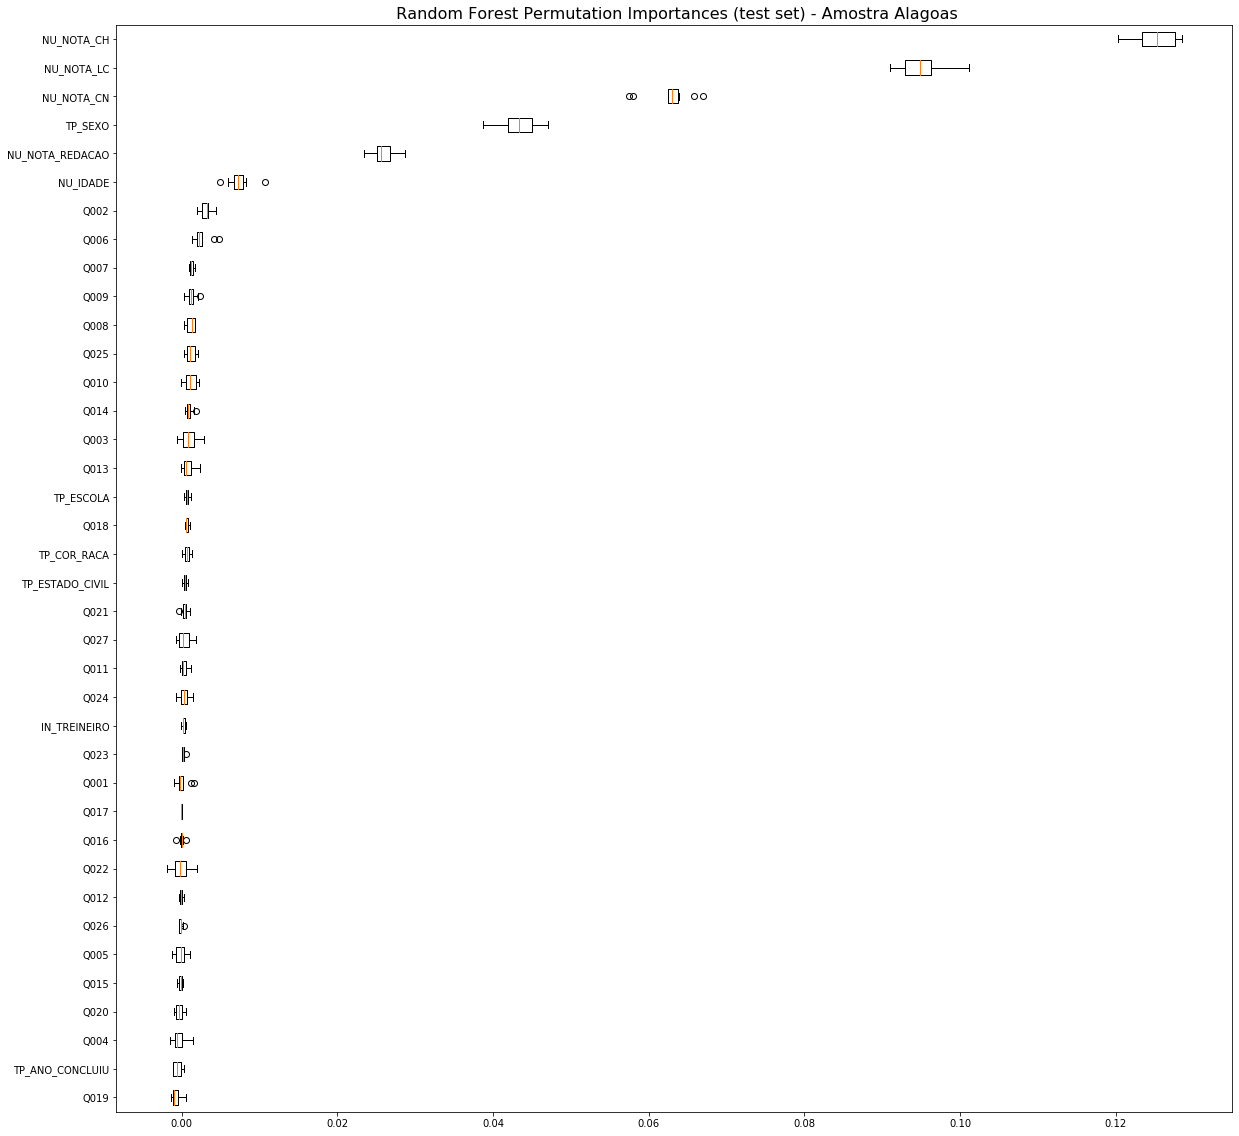

In [28]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title(" Random Forest Permutation Importances (test set) - Amostra Alagoas", fontsize=16)
ax.set_ylabel(fontsize = 13)
fig.tight_layout(pad=1.08, h_pad=5, w_pad=5, rect=None)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
plt.savefig('imagens/permutationImportances_RF_MT_AL.png', format='png')

plt.show()

TypeError: set_ylabel() missing 1 required positional argument: 'ylabel'

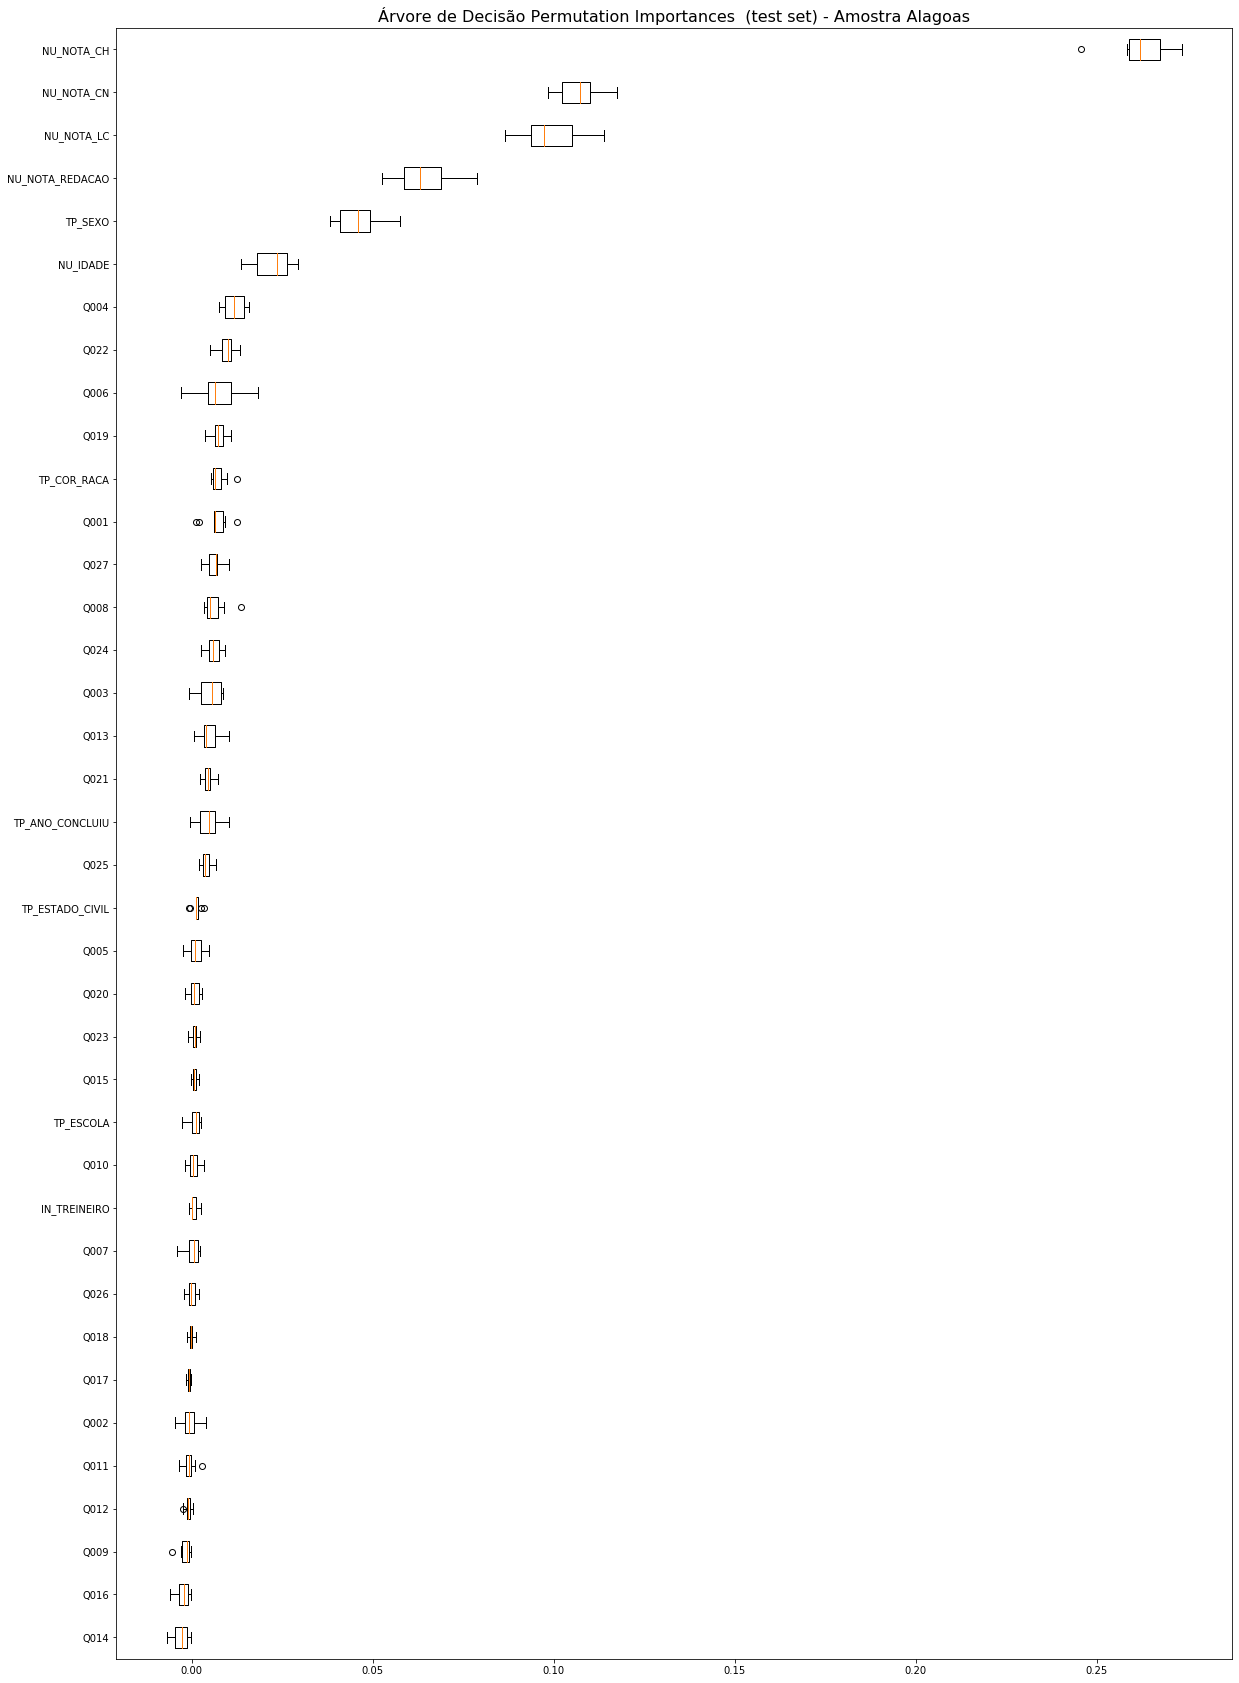

In [30]:
result_dt = permutation_importance(dtree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result_dt.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20, 30))
ax.boxplot(result_dt.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Árvore de Decisão Permutation Importances  (test set) - Amostra Alagoas", fontsize=16)
ax.set_ylabel(fontsize = 13)
fig.tight_layout(pad=1.08, h_pad=5, w_pad=5, rect=None)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
plt.savefig('imagens/permutationImportances_Dtree_AL.png', format='png')

plt.show()

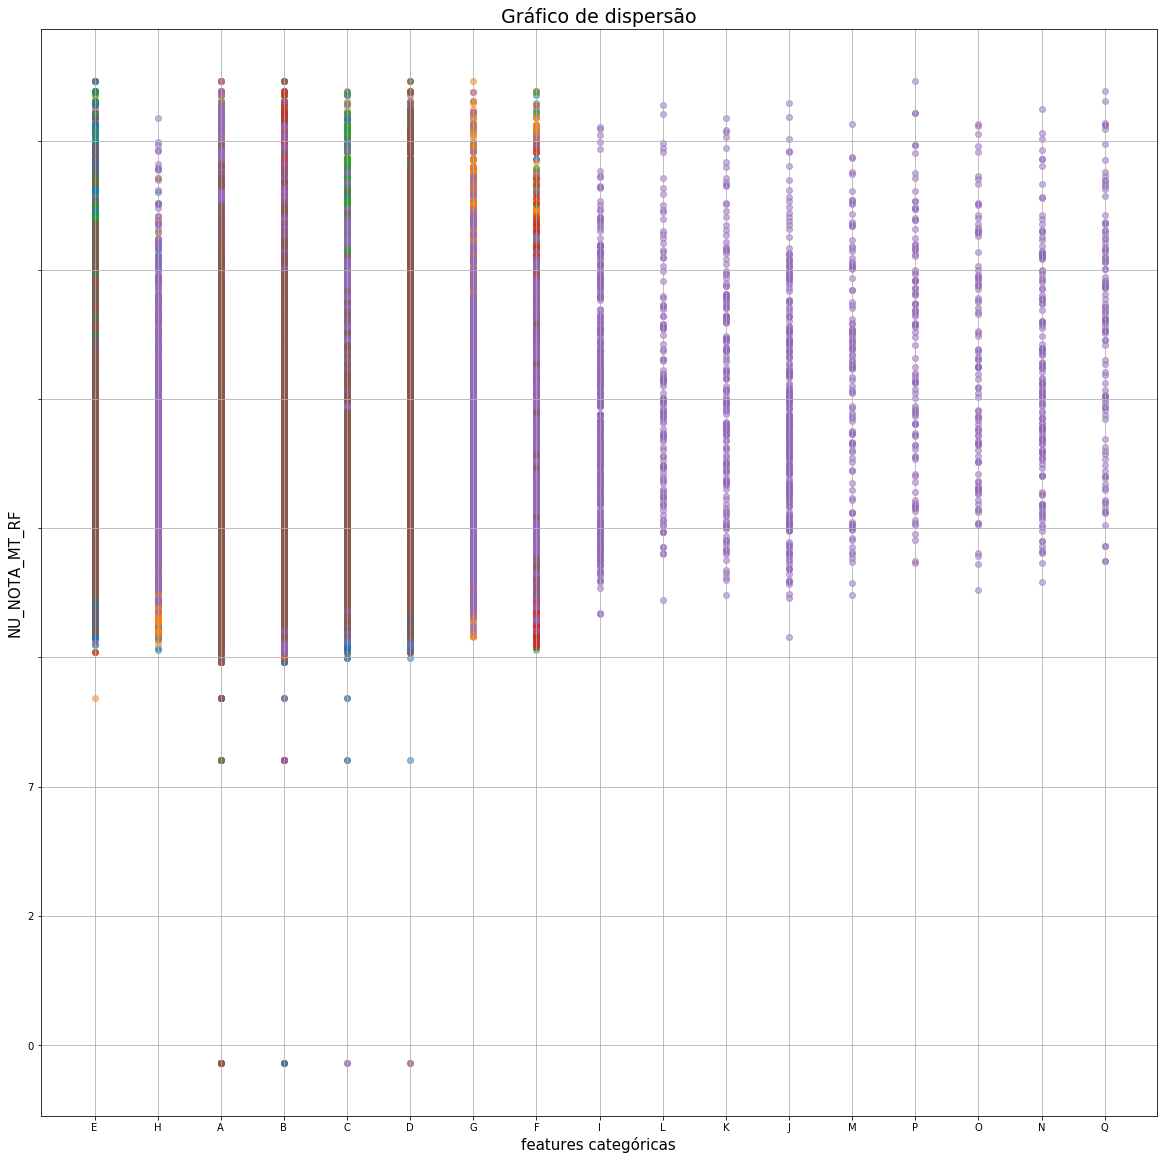

In [35]:


y_ticks = np.arange(0,len(feature_names))
#c = np.random.randint(1, 20, size=N)
fig, ax = plt.subplots(figsize=(20, 20))
labels = categorical_features
for l  in  labels:  
    ax.scatter(X_test[l], df_resposta['NU_NOTA_MT_Random Forest'], alpha=0.5)
    ax.set_yticklabels(l)
  #  ax.set_yticks(y_ticks)
    
plt.grid(True)
plt.xlabel('features categóricas', fontsize=15)
plt.ylabel('NU_NOTA_MT_RF', fontsize=15)
plt.title('Gráfico de dispersão', fontsize=19)

plt.savefig('imagens/graficoDispersao.png', format='png')
plt.show()

In [113]:
from time import gmtime, strftime
df_metricas
#valores
print("tempo de processamento em minutos:" , (round(elapsed_time/60, 2)))
print(time.time() )




tempo de processamento em minutos: 8.99
1587849454.7471185


In [123]:
#df_resposta.sort_index(inplace= True)
df_resposta.sort_values(by='NU_NOTA_MT', inplace = True)
df_resposta

NU_INSCRICAO  NU_NOTA_MT  NU_NOTA_MT_Random Forest  \
38470  180011090787         0.0                    320.88   
14046  180008766597         0.0                    436.19   
50395  180012184190         0.0                    485.11   
22686  180007519102         0.0                    368.58   
44244  180011344996       361.2                    514.50   
...             ...         ...                       ...   
40045  180011021843       904.0                    743.53   
63249  180012914250       906.0                    764.88   
38975  180010706830       925.8                    627.58   
55576  180013033911       949.0                    653.92   
40263  180010773717       962.0                    663.98   

       NU_NOTA_MT_Regressão Linear  NU_NOTA_MT_Rede Neural  \
38470                   368.904458              492.857858   
14046                   374.507918              541.028103   
50395                   513.666849              548.887518   
22686                   350.851999              470.231351   
44244                   533.929467              499.979182   
...                            ...                     ...   
40045                   655.499689              752.562476   
63249                   726.046851              787.212515   
38975                   621.843132              545.033304   
55576                   666.319668              665.978163   
40263                   622.756184              682.447599   

       NU_NOTA_MT_Árvore de decisão  
38470                         445.6  
14046                         429.5  
50395                         514.4  
22686                         429.1  
44244                         521.7  
...                             ...  
40045                         755.1  
63249                         769.3  
38975                         685.5  
55576                         717.6  
40263                         805.3  

[19382 rows x 6 columns]

In [127]:
x_ticks = np.arange(0, len(df_resposta['NU_INSCRICAO']))
x_ticks


array([    0,     1,     2, ..., 19379, 19380, 19381])

In [ ]:
labels = ['NU_NOTA_MT','Random Forest', 'Regressão Linear', 'Rede Neural', 'Árvore de decisão']
colunas = ['NU_NOTA_MT', 'NU_NOTA_MT_Random Forest',
       'NU_NOTA_MT_Regressão Linear', 'NU_NOTA_MT_Rede Neural',
       'NU_NOTA_MT_Árvore de decisão']


fig, ax = plt.subplots(figsize=(20, 20))

for label, coluna in zip(labels, colunas):
    ax.plot(df_resposta[coluna],x_ticks, label = label)


plt.xlabel('candidatos')
plt.ylabel('Notas de Matemática')
plt.title("Notas preditivas")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Média de votos em filmes no TMBD 5000')

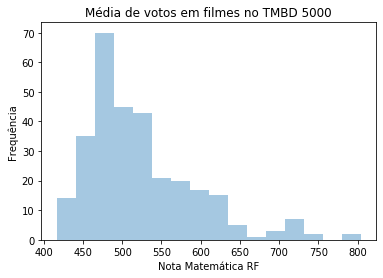

In [36]:
ax = sns.distplot(df_resposta['NU_NOTA_MT_RF'], norm_hist= False, kde= False)
ax.set(xlabel='Nota Matemática RF', ylabel='Frequência')
ax.set_title('')

# Plotando a distribuíção das notas

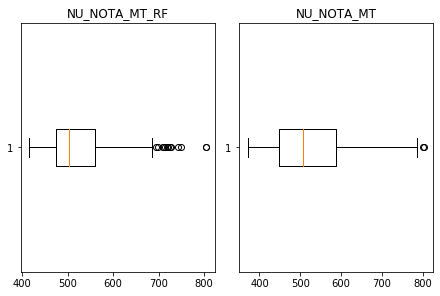

In [39]:
fig, axs = plt.subplots(1, 2, figsize=[6,4], constrained_layout=True)

idx=['NU_NOTA_MT_RF', 'NU_NOTA_MT']
for ax, i in zip(axs, ['NU_NOTA_MT_RF', 'NU_NOTA_MT']):
    ax.set_title(i)
    ax.boxplot(df_resposta[i], vert=False)

#plt.savefig('imagens/featuresImportances.png', format='png')

plt.show()


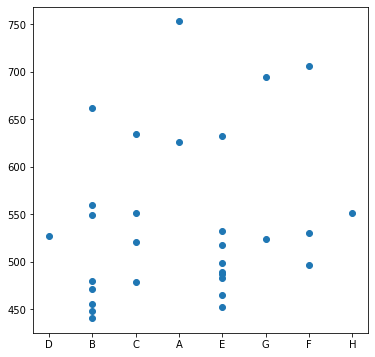

In [56]:
import matplotlib as mpl
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)
fig, ax = plt.subplots(figsize=(6, 6))
#print(X_test.sort_values('Q001')['Q001'])
ax.scatter(, df_resposta['NU_NOTA_MT_Random Forest'])

In [2]:
letras = ['A', 'B', 'C',  'D',
                 'E',
                 'F',
                 'G',
                 'H',
                 'I',
                 'J',
                 'K',
                 'L',
                 'M',
                 'N',
                 'O',
                 'P',
                 'Q']

In [39]:
sns.catplot(x="Q001", y="NU_NOTA_MT_Random Forest", data=df);

NameError: name 'df' is not defined

KeyError: 'NU_NOTA_MT_Random Forest'

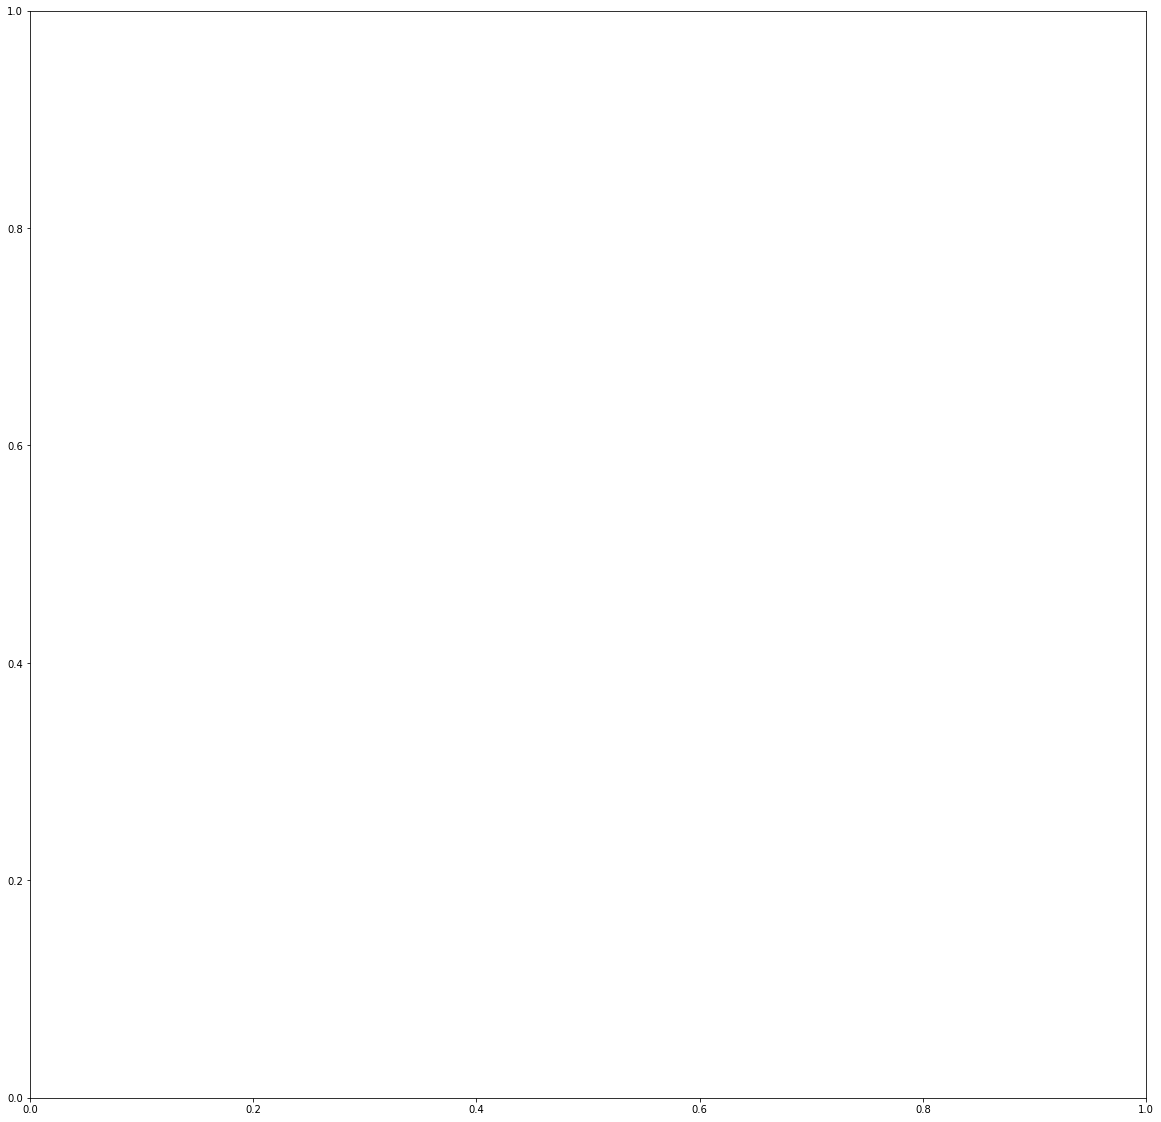

In [117]:
y_ticks = np.arange(0, len(categorical_features))
cmap = plt.cm.RdYlBu
fig, ax = plt.subplots(figsize=(20, 20))
for i in categorical_features:
    ax.scatter(X_test[i], df_resposta['NU_NOTA_MT_Random Forest'], label = i, cmap = cmap)
#ax.set_yticklabels('Q001')
#ax.set_yticks(y_ticks)

plt.grid(True)
plt.xlabel('features categóricas', fontsize=15)
plt.ylabel('NU_NOTA_MT_RF', fontsize=15)
plt.title('Gráfico de dispersão', fontsize=19)
plt.legend()
plt.show()

# Salvar a figura a qualquer momento

In [ ]:
fig = plt.gcf()
plt.show()
fig.savefig('teste.png', format='png')